## Andres Banquez Cabarcas - Andrés David Medina Herrera

In [1]:
from sklearn import preprocessing as ps
import joblib
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

C:\Users\ADMH2\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Funciones para el tratamiento de los datos

In [2]:
def datetime2str(valuee):
  if isinstance(valuee, datetime.datetime):
    return str(valuee)
  else:
    return valuee

def arreglarStrings(string):
  if isinstance(string, str):
    return string.strip().upper()
  else:
    return string

Exportamos la BD

In [3]:
df=pd.read_excel('../BD_URGENCIAS_BIO.xlsx')
df.head()

,COD,DESCRIPCION,Año,Mes,Paciente Tipo Identificacion,Nro Atencion,Servicio Admite,Servicio Anterior,Servicio Egreso,Tipo Egreso (INTERNACION),...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
0,1102,URGENCIAS ADULTO,2023,ENERO,CC,8597130640,URGENCIAS GENERALES SÓTANO,PISO 7 UCI NEUROCIRUGÍA,PISO 8 MEDICINA INTERNA NORTE,FALLECE,...,34.0,0.0,84.0,0.0,0.0,84,True,POBLACIÓN GENERAL,OTRAS ETNIAS,HIPERTENSION
1,1102,URGENCIAS ADULTO,2023,ENERO,CC,354450470,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,34.0,34,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
2,1102,URGENCIAS ADULTO,2023,ENERO,CC,4144136964,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,0.0,0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
3,1102,URGENCIAS ADULTO,2023,ENERO,CC,6090446598,HOSPITALIZACIÓN,CAMILLAS SALA 4 URGENCIAS,PISO 5 MEDICINA INTERNA NORTE,ALTA MÉDICA,...,0.0,6053.0,0.0,1092.0,0.0,1092,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
4,1102,URGENCIAS ADULTO,2023,ENERO,CC,3879330593,URGENCIAS GENERALES SÓTANO,CAMILLAS SALA 2 URGENCIAS,PISO 6 UCE,ALTA MÉDICA,...,69.0,0.0,286.0,0.0,0.0,286,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO


Aplicamos las funcionas anteiormente creadas

In [4]:
df = df.applymap(datetime2str)
df = df.applymap(arreglarStrings)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)
df['Grupo Poblacional'] = df['Grupo Poblacional'].astype(str)
df['Tiempo Duracion Diligenciamiento F3'] = df['Tiempo Duracion Diligenciamiento F3'].astype(str)
df.shape

C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\1823291755.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(datetime2str)
C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\1823291755.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(arreglarStrings)


(39745, 70)

Definimos la variable objetivo:



In [5]:
df['Tipo Egreso (INTERNACION)'].replace({'NO APLICA': 0,
                                         'ALTA MÉDICA': 1}, inplace=True) #esto es para que lueguito salgan bien las graficas, posteriormenten ponemos cero y uno

df = df[df['Tipo Egreso (INTERNACION)'].isin([0, 1])]

elementos_unicos_actualizados = df['Tipo Egreso (INTERNACION)'].value_counts()
print("Elementos únicos actualizados en la variable 'Tipo Egreso (INTERNACION)' y su cantidad:")
print(elementos_unicos_actualizados)

Elementos únicos actualizados en la variable 'Tipo Egreso (INTERNACION)' y su cantidad:
Tipo Egreso (INTERNACION)
1    20348
0    16320
Name: count, dtype: int64


C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\2628316767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tipo Egreso (INTERNACION)'].replace({'NO APLICA': 0,


Por ahora la variable objetivo la manejaremos como se mencionó en la casilla anterior, suponiendo que aquellos NO aplica son los que no quedaron hospitalizados y alta medica que quedaron, se sabe que pacientes que por ejemplo estan en camillas en Servicio Egreso quiere decir que no fueron hospitalizados, o que por ejemplos duraron mas de 24 horas en urgencias ya cuenta automaticamente como hospitalizacion, pero en este momento, para simplicidad del codigo, solo nos enfocaremos en los datos mas obvios (los que pusimos antes para hospitalizacion y no hospitalizacion) y los que acabo de mencionar los dejaremos (debido ademas a que son muy pocos datos estos) , posteiormente cuando se hagan y prueben cada uno de los modelos, se detallaran tales casos y seran agregados o eliminados de hospitalizacion o no hospitalizacion de la variables objetivo.

Ahora procederemos a verificar que columnas contienen un solo datos para posteriormente eliminar

In [6]:
unicos = df.nunique()
colUnicos = unicos[unicos == 1].index.tolist()
colUnicos

['COD', 'Año', 'Dias (Camara - F3)', 'Dias (Camara - Triaje)']

Ya tenemos el primer grupo de variables "inservibles",por lo cual se procederan a dropear

Ademas de esas variables, mediante analisis visual en la BD, se observa que hay tres columnas las cuales describen informacion post, es decir datos tomandos luego de hospitalizacion o no hospitalizacion en todo caso, por lo cual para el proceso de modelado, no deben ser tomadas en cuenta.
Por el momento se han identificado tres variables post: 'Servicio Admite', "Servicio Egreso", "Servicio Anterior"

In [7]:
df_2=df.copy()
df_2 = df.drop(colUnicos, axis = 1)
df_2 = df_2.drop(['Servicio Admite', "Servicio Egreso", "Servicio Anterior"], axis = 1)
df_2.shape

(36668, 63)

In [8]:
cdata=df_2.select_dtypes(exclude=["int","float"]).columns
dataEncode=df_2.copy()
encoder=ps.LabelEncoder()
for i in cdata:
    dataEncode[i]=encoder.fit_transform(dataEncode[i])
dataEncode.head()


,DESCRIPCION,Mes,Paciente Tipo Identificacion,Nro Atencion,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
1,0,3,1,354450470,0,5,2,3,18151,18159,...,0.0,0.0,0.0,0.0,34.0,34,0,3,2,10
2,0,3,1,4144136964,0,65,1,1,18668,18680,...,0.0,0.0,0.0,0.0,0.0,0,0,3,2,10
3,0,3,1,6090446598,1,48,1,0,18942,18957,...,0.0,6053.0,0.0,1092.0,0.0,1092,1,3,2,10
4,0,3,1,3879330593,1,19,1,0,18633,18645,...,69.0,0.0,286.0,0.0,0.0,286,0,3,2,10
5,1,3,8,502678254,0,48,1,0,18173,18182,...,0.0,0.0,0.0,0.0,73.0,73,0,3,2,10


In [9]:
def corrMatrix(dataEncode):
    corr_matrix = dataEncode.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    target_corr_df
    dataEncodePartida=dataEncode[target_corr_df.index[:12]]
    dataEncodePartida
    corr_matrix = dataEncodePartida.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    plt.figure(figsize=(10,10))
    sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
    plt.show()

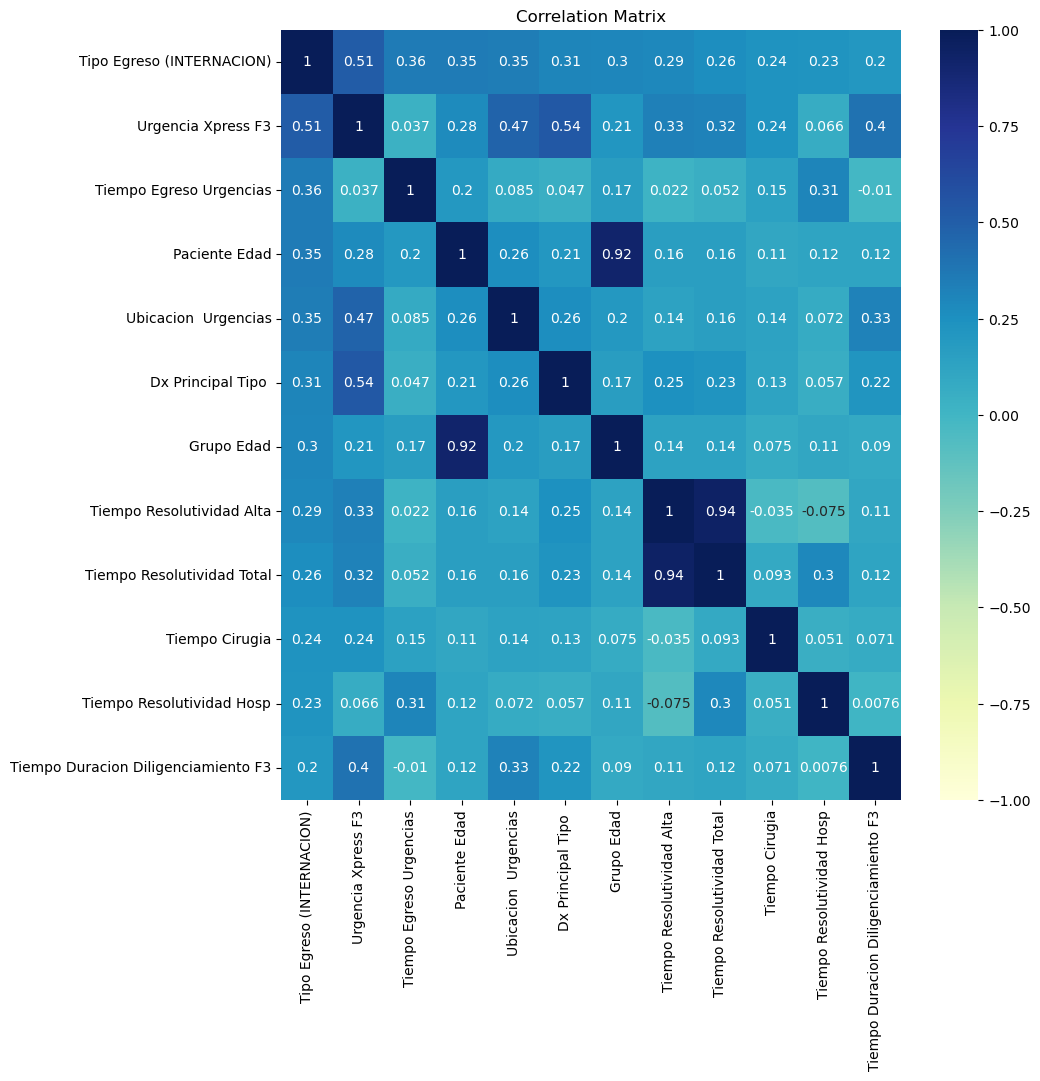

In [10]:
corrMatrix(dataEncode)

En la matriz de correlacion se observa que hay dos variables que resultan ser combinancion lineal de otras, es decir que ya tenemos dos varables mas a eliminar debido a que no aportan informacion valiosa.

Ademas de ello, se analizo el significado de la variables Tiempo Resolutividad Alta, y se concluyó que esta variable pertenece al grupo post (es decir, variables procedentes luego del proceso de hospitalizacion), por ende no deben tomarse para el proceso de modelado; la misma situacion suede con Tiempo Resolutividad Total, Tiempo Resolutividad Cx y Tiempo Resolutividad Hosp. 
Es decir, 5 variables mas a eliminar al considerarse nada utiles.

In [11]:
drop = [i for i in dataEncode.columns.tolist() if i.startswith("Tiempo Resolutividad")]
drop.append("Paciente Edad")
df_3=df_2.copy()
df_3.drop(drop, inplace=True, axis=1)
dataEncode.drop(drop, inplace=True, axis=1)
dataEncode.shape  
df_3.shape

(36668, 58)

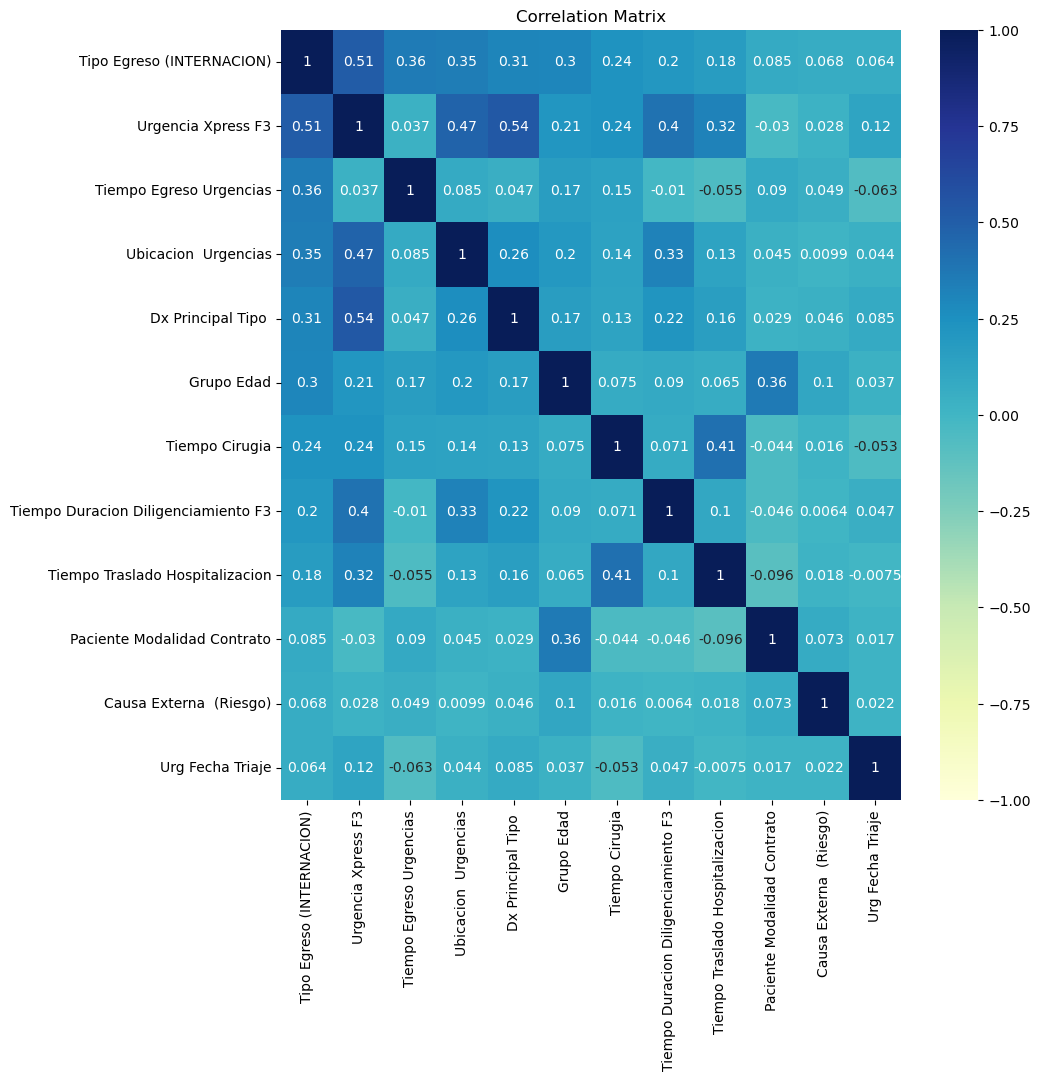

In [15]:
corrMatrix(dataEncode)

Analizando estas variables, se observa poca correlacion, entonces se procede a hacer una inspeccion visual del diccionario de variables, observandose que respecto al diagnostico principal hay varias variables que aportan exactamente la misma informacion, y que por ende se pueden proceder a eliminar:

In [16]:
delCols = [i for i in dataEncode.columns.tolist() if i.startswith("Dx") and (not ("Cod" in i) or ("Capitulo" in i)) and (not ("Tipo" in i))]
for i in delCols:
    print(i)


Dx Principal
Dx Principal Capitulo Cod
Dx Principal Capitulo

Dx Principal.1
Dx Relacionado1

Dx Relacionado2

Dx Relacionado3



In [17]:
dataEncode.drop(delCols, inplace=True, axis=1)
df_3.drop(delCols, inplace=True, axis=1)
print(dataEncode.shape)
print(df_3.shape)

(36668, 51)
(36668, 51)


Se eliminan las variables de horas y días porque se pueden considerar una combinación lineal con la variable de minutos que es mas diciente ya que no esta normalizada, ni cortada por sus decimales.

In [18]:
delCols = [i for i in dataEncode.columns.tolist() if (("horas" in i.lower()) or ("dias" in i.lower()))]
delCols

['Horas (Camara - F3)',
 'Horas (Camara - Triaje)',
 'Dias (Triaje - F3)',
 'Horas (Triaje - F3)',
 'Dias',
 'Horas']

In [19]:
dataEncode.drop(delCols, inplace=True, axis=1)
df_3.drop(delCols, inplace=True, axis=1)
print(dataEncode.shape)
print(df_3.shape)

(36668, 45)
(36668, 45)


Quedando la BD entonces de la siguiente manera:

In [20]:
df_3

,DESCRIPCION,Mes,Paciente Tipo Identificacion,Nro Atencion,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,...,Hora Diligenciamiento F3,Minutos,Triaje Re-clasificado,Tiempo Egreso Urgencias,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
1,URGENCIAS ADULTO,ENERO,CC,354450470,0,5,PGP,SUBSIDIADO,2023-01-01 14:14:06.223000,2023-01-01 14:36:29.597000,...,0.638356,56.0,NO,52.0,0.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
2,URGENCIAS ADULTO,ENERO,CC,4144136964,0,65,EVENTO,ESPECIAL,2023-01-07 18:21:27.977000,2023-01-07 18:32:07.223000,...,0.821887,79.0,NO,0.0,0.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
3,URGENCIAS ADULTO,ENERO,CC,6090446598,1,48,EVENTO,CONTRIBUTIVO,2023-01-11 11:19:16.737000,2023-01-11 11:19:16.800000,...,0.712373,0.0,NO,1432.0,0.0,6053.0,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
4,URGENCIAS ADULTO,ENERO,CC,3879330593,1,19,EVENTO,CONTRIBUTIVO,2023-01-07 10:08:49.397000,2023-01-07 10:40:49.950000,...,0.503935,108.0,SI,384.0,69.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
5,URGENCIAS PEDIATRICAS,ENERO,RC,502678254,0,48,EVENTO,CONTRIBUTIVO,2023-01-01 19:55:33.970000,2023-01-01 20:04:34.377000,...,0.845150,17.0,NO,0.0,0.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,URGENCIAS ADULTO,DICIEMBRE,CC,275182366826,0,65,EVENTO,ESPECIAL,31/12/2023 2:46:48,31/12/2023 3:07:12,...,0.150648,36.0,NO,168.0,0.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39740,URGENCIAS ADULTO,DICIEMBRE,CC,266200248216,1,4,EVENTO,SUBSIDIADO,17/12/2023 2:06:21,17/12/2023 2:21:27,...,0.141713,74.0,NO,712.0,70.0,3459.0,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39741,URGENCIAS ADULTO,DICIEMBRE,CC,271388292512,0,18,EVENTO,NO ASEGURADO,25/12/2023 9:16:35,25/12/2023 9:40:47,...,0.414919,34.0,NO,159.0,0.0,0.0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39742,URGENCIAS ADULTO,DICIEMBRE,CC,274133627340,0,18,EVENTO,NO ASEGURADO,29/12/2023 11:20:02,29/12/2023 11:48:00,...,0.507465,48.0,NO,116.0,0.0,0.0,True,POBLACIÓN GENERAL,NEGRO (A). MULATO (A). AFROCOLOMBIANO (A) O AF...,ZNO ALTO COSTO


Las siguientes variables que puedan o deban ser eliminadas o tratadas de alguna manera, se haran en el camino, ahora se procederá con el Analisis estadistico y visualizacion de los datos:

Ahora nos enfocamos en borrar variables post-internación, ya que nos dicen directamente que el paciente ya fué internado.

In [21]:
delCols = ['Tiempo Cirugia', 'Tiempo Traslado Hospitalizacion',
           'Tiempo Egreso Urgencias']
df_3.drop(delCols, inplace=True, axis=1)
df_3.shape  

(36668, 42)

Nro Atención se va porque no aporta información ya que es un numero diferente para cada paciente. Paciente Tipo Identificación se va porque representa casi lo mismo que DESCRIPCION.
Eliminamos Clasificacion Urg (Nivel)\nEnfermeria porque representa lo mismo que Clasificacion 1 Triaje \nEnfermeria

In [22]:
delCols = ['Paciente Tipo Identificacion', 'Nro Atencion', 'Clasificacion Urg (Nivel)\nEnfermeria ']
df_3.drop(delCols, inplace=True, axis=1)
df_3.shape  

(36668, 39)

Ahora, considerando que ya se eliminaron las variables mas obvias de eliminar, procederemos con un breve analisis estadistico y visualizacion de la data que queda

Primero analicemos si hay datos nulos presentes

In [23]:
datos_nulos = df_3.isnull().sum()
porcentaje_nulos = (datos_nulos / len(df_3)) * 100

# Creamos una tablita para mejor visualizacion
resultados = pd.DataFrame({'Datos Nulos': datos_nulos, 'Porcentaje de Nulos': porcentaje_nulos})
print("Cantidad de datos nulos por columna y su porcentaje:")
resultados

Cantidad de datos nulos por columna y su porcentaje:


,Datos Nulos,Porcentaje de Nulos
DESCRIPCION,0,0.000000
Mes,0,0.000000
Tipo Egreso (INTERNACION),0,0.000000
Paciente Entidad Responsable Pago,0,0.000000
Paciente Modalidad Contrato,0,0.000000
Paciente Regimen Afiliacion,5,0.013636
Urg Fecha (Camara),0,0.000000
Urg Fecha Ingreso,0,0.000000
Urg Fecha Triaje,2454,6.692484
Urg Fecha Consulta F3,0,0.000000


Se observan ciertas variables con datos nulos con porcentahes inferiores al 1% (para estas variables se les imputará la media o la moda segunda sea, para estos datos nulos, ya que al considerarse tan pequeño el porcentaje no inducira mucho ruido en el modelado, y aportarian informacion en las demas variables en las que se posee data), el resto de variables que presentan datos nulos se les hara un analisis especifico al momento de la codificacion final ya que no deben ser eliminadas debido a su importancia, requiriendo un manejo especial, es decir, que no las tocaremos mucho en este analisis.

In [24]:
limite_reemplazo = len(df_3) * 0.05
for columna in df_3.columns:
    cantidad_nulos = df_3[columna].isnull().sum()
    if cantidad_nulos < limite_reemplazo:
        # Aqui verifico si la columna es numerica o no
        if df_3[columna].dtype == 'object':
            moda = df_3[columna].mode()[0]
            df_3[columna].fillna(moda, inplace=True)
        #Si es numerica
        else:
            promedio = df_3[columna].mean()
            df_3[columna].fillna(promedio, inplace=True)


C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3216288688.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_3[columna].fillna(moda, inplace=True)
C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3216288688.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [25]:
datos_nulos = df_3.isnull().sum()
porcentaje_nulos = (datos_nulos / len(df_3)) * 100

# Creamos una tablita para mejor visualizacion
resultados = pd.DataFrame({'Datos Nulos': datos_nulos, 'Porcentaje de Nulos': porcentaje_nulos})
print("Cantidad de datos nulos por columna y su porcentaje:")
resultados

Cantidad de datos nulos por columna y su porcentaje:


,Datos Nulos,Porcentaje de Nulos
DESCRIPCION,0,0.000000
Mes,0,0.000000
Tipo Egreso (INTERNACION),0,0.000000
Paciente Entidad Responsable Pago,0,0.000000
Paciente Modalidad Contrato,0,0.000000
Paciente Regimen Afiliacion,0,0.000000
Urg Fecha (Camara),0,0.000000
Urg Fecha Ingreso,0,0.000000
Urg Fecha Triaje,2454,6.692484
Urg Fecha Consulta F3,0,0.000000


Se observa entonces que aquellas variables con porcentajes minimos de datos nulos, ya no presentan estos. Arreglada esta situacion se procede al analisis de las primeras variables.

In [88]:
df_3

,DESCRIPCION,Mes,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,Urg Fecha Triaje,Urg Fecha Consulta F3,...,Ubicación Triaje,Profesional Identificacion,Tiempo Duracion Diligenciamiento F3,Hora Diligenciamiento F3,Minutos,Triaje Re-clasificado,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
1,URGENCIAS ADULTO,ENERO,0,5,PGP,SUBSIDIADO,2023-01-01 14:14:06.223000,2023-01-01 14:36:29.597000,2023-01-01 14:23:34.717000,2023-01-01 15:19:13.777000,...,TRAUMA,1.163025e+11,18:48,0.638356,56.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
2,URGENCIAS ADULTO,ENERO,0,65,EVENTO,ESPECIAL,2023-01-07 18:21:27.977000,2023-01-07 18:32:07.223000,2023-01-07 18:24:41.357000,2023-01-07 19:43:31.250000,...,CONSULTORIO 1,8.036132e+10,18:55,0.821887,79.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
3,URGENCIAS ADULTO,ENERO,1,48,EVENTO,CONTRIBUTIVO,2023-01-11 11:19:16.737000,2023-01-11 11:19:16.800000,NaN,2023-01-11 17:05:49.203000,...,XPRESS,1.047977e+11,0,0.712373,0.0,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
4,URGENCIAS ADULTO,ENERO,1,19,EVENTO,CONTRIBUTIVO,2023-01-07 10:08:49.397000,2023-01-07 10:40:49.950000,2023-01-07 10:17:25.067000,2023-01-07 12:05:40.207000,...,CONSULTORIO 1,7.425727e+10,30:32,0.503935,108.0,SI,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
5,URGENCIAS PEDIATRICAS,ENERO,0,48,EVENTO,CONTRIBUTIVO,2023-01-01 19:55:33.970000,2023-01-01 20:04:34.377000,2023-01-01 20:00:38.977000,2023-01-01 20:17:01.273000,...,CONSULTORIO PEDIATRIA,1.310760e+11,5:41,0.845150,17.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,URGENCIAS ADULTO,DICIEMBRE,0,65,EVENTO,ESPECIAL,31/12/2023 2:46:48,31/12/2023 3:07:12,31/12/2023 3:00:41,31/12/2023 3:36:56,...,CONSULTORIO 1,1.543998e+11,22:27,0.150648,36.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39740,URGENCIAS ADULTO,DICIEMBRE,1,4,EVENTO,SUBSIDIADO,17/12/2023 2:06:21,17/12/2023 2:21:27,17/12/2023 2:10:47,17/12/2023 3:24:04,...,CONSULTORIO 4,8.571620e+10,nan,0.141713,74.0,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39741,URGENCIAS ADULTO,DICIEMBRE,0,18,EVENTO,NO ASEGURADO,25/12/2023 9:16:35,25/12/2023 9:40:47,25/12/2023 9:23:32,25/12/2023 9:57:29,...,TRAUMA,1.058367e+11,10:48,0.414919,34.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
39742,URGENCIAS ADULTO,DICIEMBRE,0,18,EVENTO,NO ASEGURADO,29/12/2023 11:20:02,29/12/2023 11:48:00,29/12/2023 11:22:22,29/12/2023 12:10:45,...,XPRESS,7.018706e+10,nan,0.507465,48.0,NO,True,POBLACIÓN GENERAL,NEGRO (A). MULATO (A). AFROCOLOMBIANO (A) O AF...,ZNO ALTO COSTO


In [29]:
#Esta parte del codigo es para que las graficas salgan mejorcito
# Reemplazar los valores en la columna "Citas"
df_31=df_3.copy()
df_31['Tipo Egreso (INTERNACION)'] = df_31['Tipo Egreso (INTERNACION)'].replace({0: 'No hospitalizacion', 1: 'Hospitalizacion'})



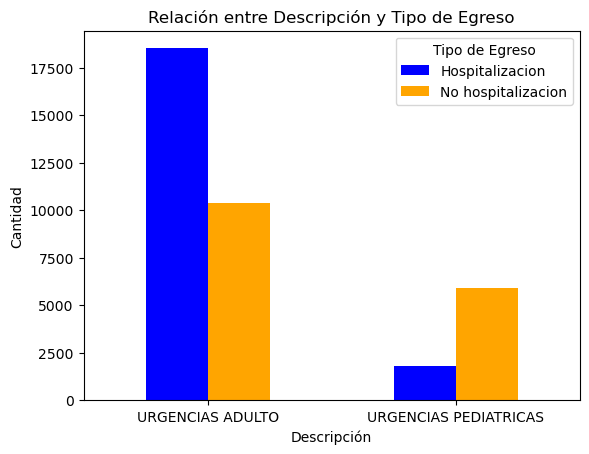

In [30]:
import matplotlib.pyplot as plt


conteo = df_31.groupby(['DESCRIPCION', 'Tipo Egreso (INTERNACION)']).size().unstack()
conteo.plot(kind='bar', color=['blue', 'orange'])
plt.title('Relación entre Descripción y Tipo de Egreso')
plt.xlabel('Descripción')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Egreso')

plt.show()

Se observa que la variables DESCRIPCION, tiene gran importancia, ya que hay una clara diferencia entre los datos de esta con respecto a la salida.

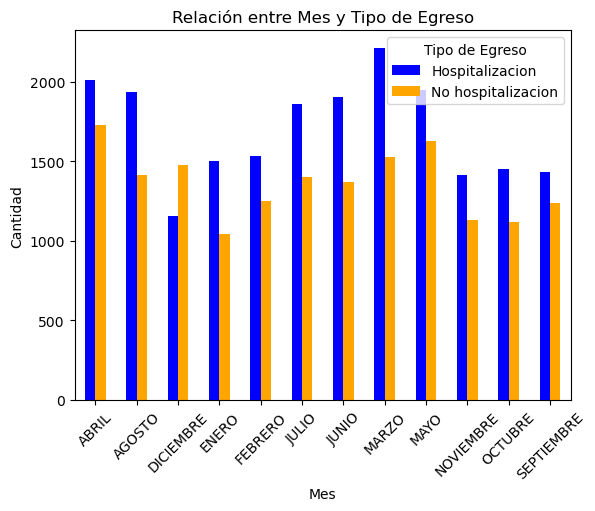

In [31]:
conteo_mes = df_31.groupby(['Mes', 'Tipo Egreso (INTERNACION)']).size().unstack()
conteo_mes.plot(kind='bar', color=['blue', 'orange'])
plt.title('Relación entre Mes y Tipo de Egreso')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

plt.show()


Aunque en la varible MES se observa la misma tendencia en todos los meses aproximadamente (Numero de pacientes en hospitalizacion siendo mucho menos que pacientes No hospitalizados), hay un mes donde no se aprecia tal tendencia, y otros donde se observa de manera diferente, por lo cual esta variable podria aportar ciertamente al proceso de clasificacion.

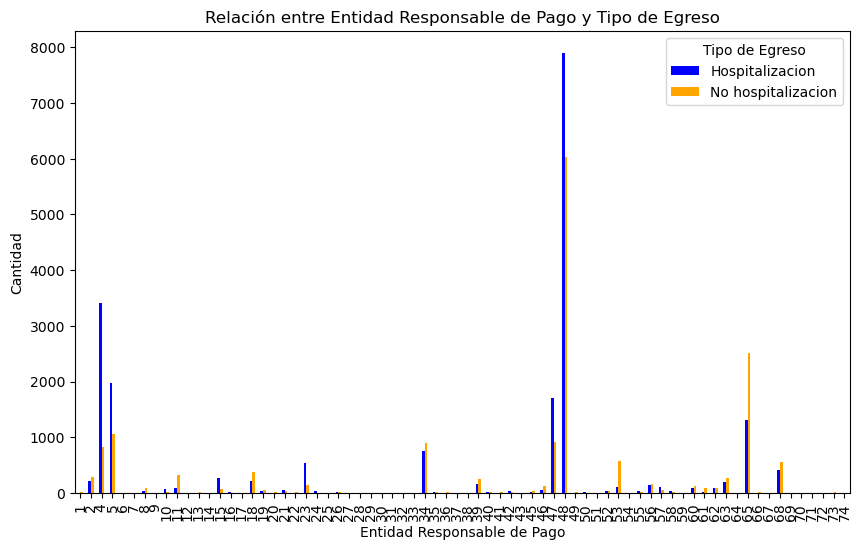

In [32]:
conteo_entidad_pago = df_31.groupby(['Paciente Entidad Responsable Pago', 'Tipo Egreso (INTERNACION)']).size().unstack()

conteo_entidad_pago.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))
plt.title('Relación entre Entidad Responsable de Pago y Tipo de Egreso')
plt.xlabel('Entidad Responsable de Pago')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.legend(title='Tipo de Egreso')


plt.show()

Con respecto a la entidad responsable de Pago, aunque no deberia ser un factor determinante para decir si los pacientes se quedan en Hospitalizacion o No (es decir que deberia en todas representarse el mismo comportamiento aproximado, donde el numero de hospitalizados sea mayor al numero de No Hositalizados), los datos dicen otra cosa, observandose que en ciertas entidades los pacientes tienden a ser no Hospitalizados mayormente, mientras que en otras la mayoria son Hospitalizados, por ende esta variable se considerará de importancia tambien.

Vamos con la siguiente variables:
Paciente Modalidad Contrato.
Procedemos primero a verificar los valores unicos que este posee y la cantidad de estos:

In [33]:
elementos_unicos_ModContrato = df_31['Paciente Modalidad Contrato'].value_counts()
print("Elementos únicos en la variable 'Paciente Modalidad Contrato' y su cantidad:")
print(elementos_unicos_ModContrato)

Elementos únicos en la variable 'Paciente Modalidad Contrato' y su cantidad:
Paciente Modalidad Contrato
EVENTO    30987
PGP        5650
CAPITA       31
Name: count, dtype: int64


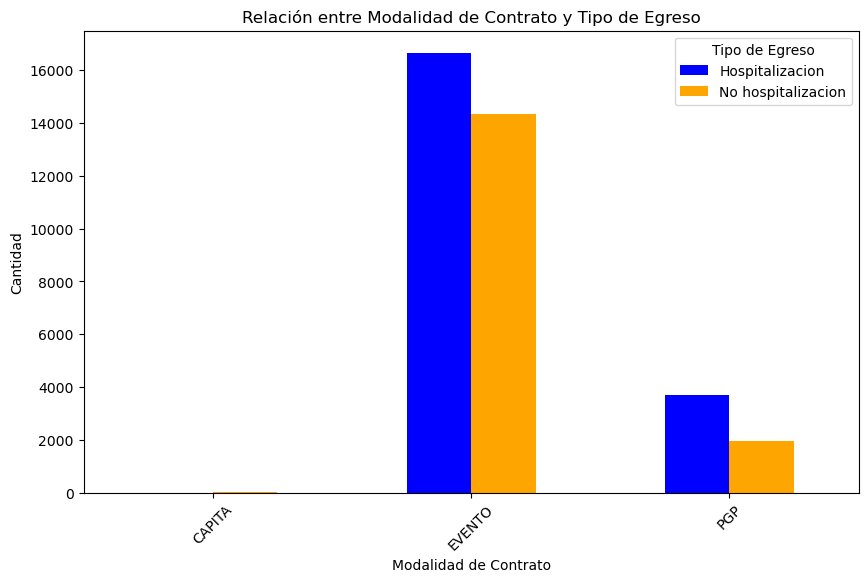

In [34]:
conteo_modalidad_contrato = df_31.groupby(['Paciente Modalidad Contrato', 'Tipo Egreso (INTERNACION)']).size().unstack()

conteo_modalidad_contrato.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))
plt.title('Relación entre Modalidad de Contrato y Tipo de Egreso')
plt.xlabel('Modalidad de Contrato')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

plt.show()

En la variable Paciente Modalidad Contrato se observan tendencia similares en los datos que se tienen, por ende se podria decir que esta variable no aporta mucha informacion para clasificar un paciente entre Hospitalizacion y No hospitalizacion, de igual forma se dejará esta.

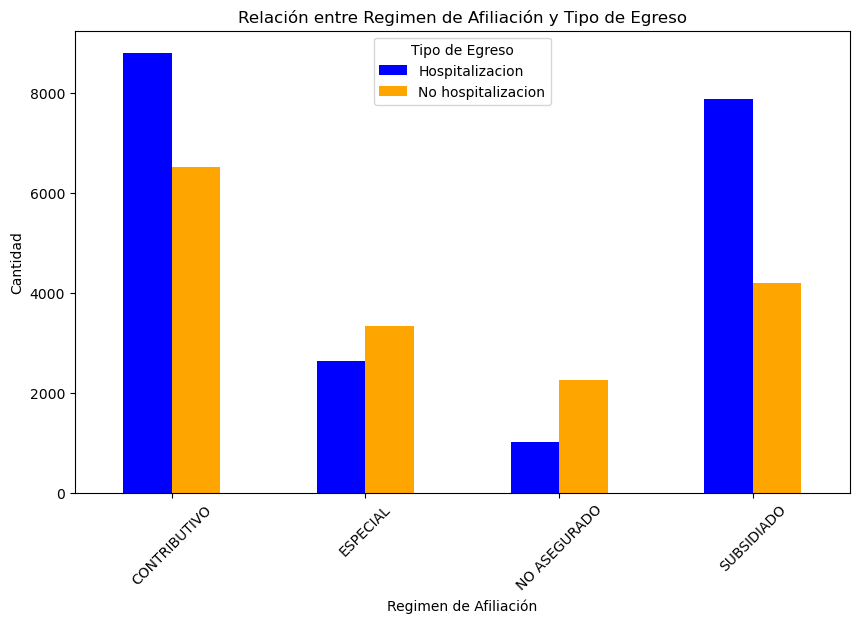

In [35]:
conteo_regimen_afiliacion = df_31.groupby(['Paciente Regimen Afiliacion', 'Tipo Egreso (INTERNACION)']).size().unstack()

conteo_regimen_afiliacion.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

plt.title('Relación entre Regimen de Afiliación y Tipo de Egreso')
plt.xlabel('Regimen de Afiliación')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

plt.show()

Con la variable Regimen Afiliacion, se observan comportamientos diferentes en algunos de los datos; al ser esta ESPECIAL o NO ASEGURADO, hay mayor cantidad de pacientes que no se quedan en Hospitalizacion, es decir que esta variable aporta informacion importante en el proceso de seleccion (lo cual no deberia).

Las siguientes variables a analizar no seran exactamente categoticas, ya que se analizaran fechas en busqueda de algun patron que el modelo pueda agradecer posteiormente.

SE ANALIZARÁ PRIMERO Urg Fecha (Camara), QUE ES LA HORA A LA CUAL LA CEDULA DEL PACIENTE ES ESCANEADA, ES DECIR LA HORA A LA CUAL LLEGA AL SERVICIO DE URGENCIAS.

In [43]:
z=df_31['Urg Fecha (Camara)'][299]
print(z)
type(z)

2023-01-04 17:42:57.917000


str

C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\604957414.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_dias_por_hora = df_31.groupby('Hora').apply(lambda x: x['Urg Fecha (Camara)'].dt.date.nunique()) #esta linea la hizo chatgpt, pero esta mela


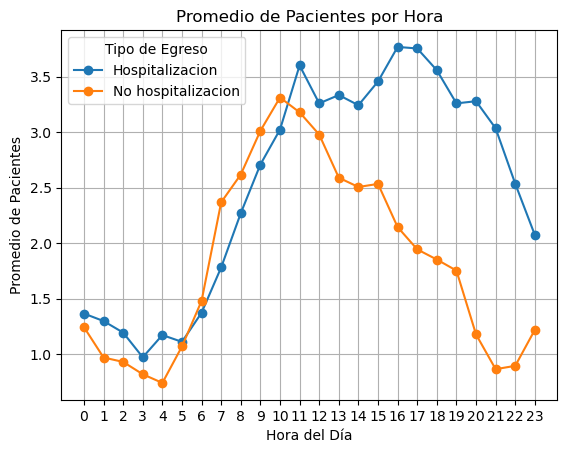

In [46]:
# Convertir la columna urg fecha camara a formato de fecha y hora porque alguien por ahí la volvio str
df_31['Urg Fecha (Camara)'] = pd.to_datetime(df_31['Urg Fecha (Camara)'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
df_31['Urg Fecha (Camara)'] = pd.to_datetime(df_31['Urg Fecha (Camara)'], errors='coerce', format='%d/%m/%Y %H:%M:%S')
df_31['Hora'] = df_31['Urg Fecha (Camara)'].dt.hour
conteo_por_hora = df_31.groupby(['Hora', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0) #se agrupa por hora y cuenta el número de pacientes hospitalizados y no hospitalizados
# Calcular el promedio 
# Contamos el número de días en que se registraron datos para cada hora
num_dias_por_hora = df_31.groupby('Hora').apply(lambda x: x['Urg Fecha (Camara)'].dt.date.nunique()) #esta linea la hizo chatgpt, pero esta mela
# Dividimos la sumatoria de pacientes por el número de días para obtener el promedio, se podria hacer con el numero total por hora, pero el comportamiento es exactamente el mismo
promedio_por_hora = conteo_por_hora.div(num_dias_por_hora, axis=0)

#aqui para crear la grafica de lineas creo, no se chat gpt hizo esta parte que sigue
promedio_por_hora.plot(kind='line', marker='o')


plt.title('Promedio de Pacientes por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Pacientes')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title='Tipo de Egreso')
plt.show()


De la variable Urf Fecha (Camara), se decidio analizar meramente la hora, es decir la hora de llegada del paciente. Y aunque se esperario que ello no influyera en si es hospitalizado o no, nuevamente los datos dicen otra cosa, observandose que en horas de la mañana (entre 5 y 10 de la mañana aproximadamente) es un poco mas probable que los pacientes que lleguen no sean hospitalizados, mientras que en las horas de la tarde hasta la media noche, es mucho mas probable que los pacientes que lleguen, entren a hospitalizacion.
De esta variable se desecha el año y el mes, ademas de los minutos, las dos primeras debido a que ya se habian eliminado o ya estaban en otra variable y la ultima porque realmente no se presentará algun patron apreciable si se analiza el minuto de llegada ya que este es basicamete azar. 
Con respecto a los minutos se harán analisis en otras variables mas adelante

C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\2468947798.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_dias_por_hora_ingreso = df_31.groupby('Hora Ingreso').apply(lambda x: x['Urg Fecha Ingreso'].dt.date.nunique())


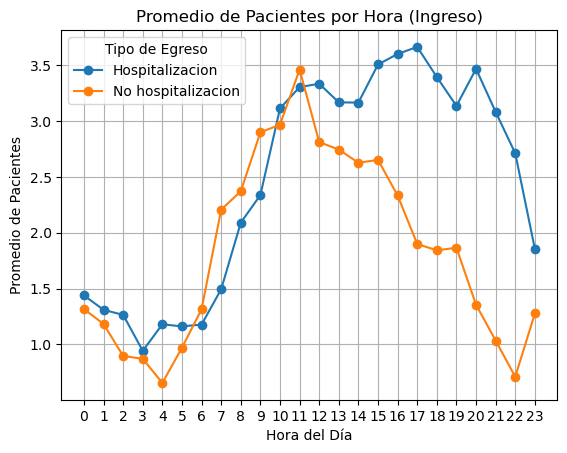

In [48]:
df_31['Urg Fecha Ingreso'] = pd.to_datetime(df_31['Urg Fecha Ingreso'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
df_31['Urg Fecha Ingreso'] = pd.to_datetime(df_31['Urg Fecha Ingreso'], errors='coerce', format='%d/%m/%Y %H:%M:%S')

df_31['Hora Ingreso'] = df_31['Urg Fecha Ingreso'].dt.hour
conteo_por_hora_ingreso = df_31.groupby(['Hora Ingreso', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)
# Calcular el promedio
# Contar el número de días en que se registraron datos para cada hora
num_dias_por_hora_ingreso = df_31.groupby('Hora Ingreso').apply(lambda x: x['Urg Fecha Ingreso'].dt.date.nunique())

# Dividir la sumatoria de pacientes por el número de días para obtener el promedio
promedio_por_hora_ingreso = conteo_por_hora_ingreso.div(num_dias_por_hora_ingreso, axis=0)
promedio_por_hora_ingreso.plot(kind='line', marker='o')

plt.title('Promedio de Pacientes por Hora (Ingreso)')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Pacientes')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title='Tipo de Egreso')
plt.show()


Se observa exactamente el mismo comportamiento que en la anterior variable, por ende el analisis es el mismo.
(Considerandose eliminarla debido a que no aporta nueva informacion).

NOTA: Con respecto a la variable anterior (Urg Fecha (Camara)) para el modelado se eliminará esta y se agregará otra meramente con las horas.
Así:

In [ ]:
df_31['Urg Fecha (Camara)'] = pd.to_datetime(df_31['Urg Fecha (Camara)'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
df_31['Urg Fecha (Camara)'] = pd.to_datetime(df_31['Urg Fecha (Camara)'], errors='coerce', format='%d/%m/%Y %H:%M:%S')

df_31['Hora'] = df_31['Urg Fecha (Camara)'].dt.hour
df_31 = df_31.drop(columns=['Urg Fecha (Camara)'])

In [51]:
# Mostramos los primeros registros para verificar
print(df_31[['Hora']].head())

   Hora
1  14.0
2  18.0
3  11.0
4  10.0
5  19.0


Ahora, se analizaran 4 variables que podrian ser de importancia:
Minutos (Camara - F3)
Urg Demora Triaje (Minutos)
Urg Demora2 Consulta (Minutos)

C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\1228647418.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=hospitalizacion['Minutos (Camara - F3)'], shade=True, color='blue')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\1228647418.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=no_hospitalizacion['Minutos (Camara - F3)'], shade=True, color='red')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

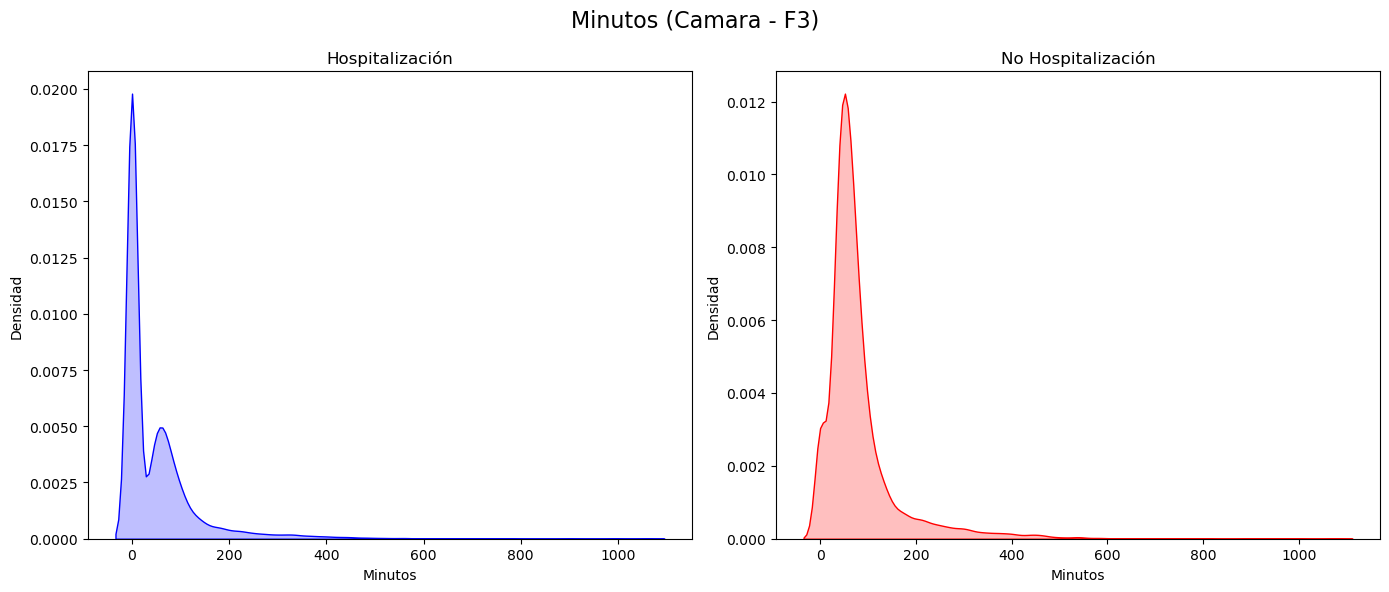

In [77]:
import seaborn as sns
# Filtrar datos para 'Hospitalizacion' y 'No hospitalizacion'
hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'Hospitalizacion']
no_hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'No hospitalizacion']

# Crear dos subplots con gráficos de densidad
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=hospitalizacion['Minutos (Camara - F3)'], shade=True, color='blue')
plt.title('Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')

plt.subplot(1, 2, 2)
sns.kdeplot(data=no_hospitalizacion['Minutos (Camara - F3)'], shade=True, color='red')
plt.title('No Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')


plt.suptitle('Minutos (Camara - F3)', fontsize=16)
plt.tight_layout()

plt.show()


C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3408696000.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=hospitalizacion['Urg Demora Triaje (Minutos)\n'], shade=True, color='blue')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3408696000.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=no_hospitalizacion['Urg Demora Triaje (Minutos)\n'], shade=True, color='red')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

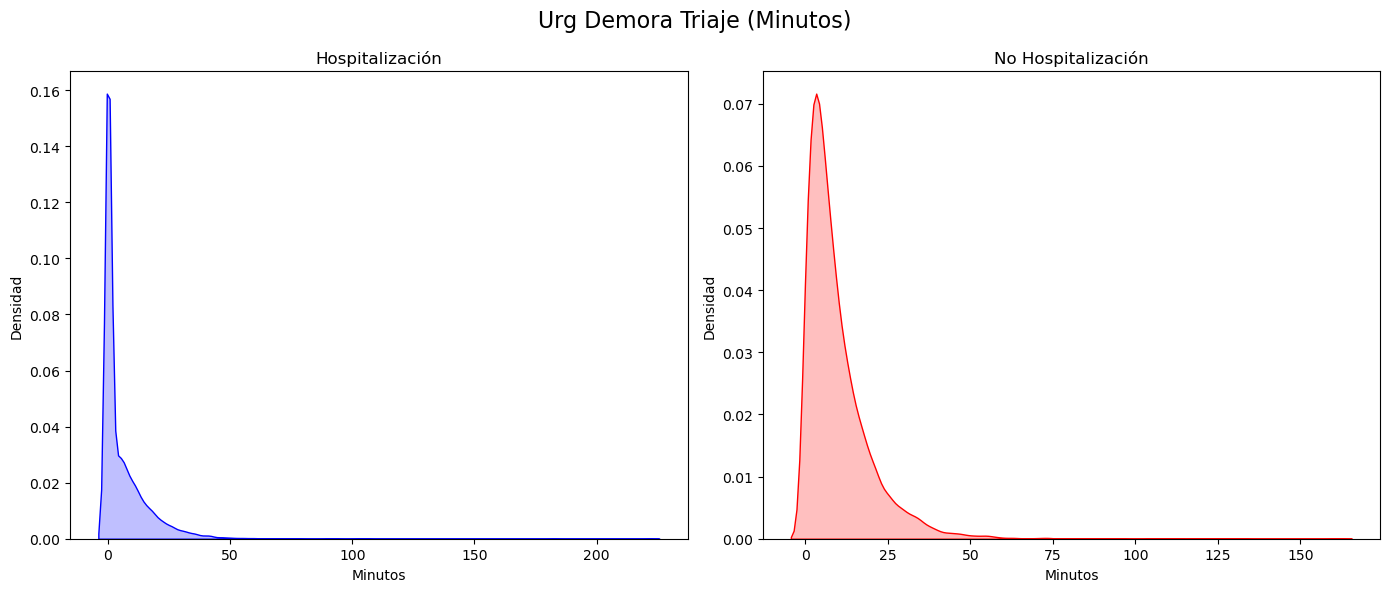

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos para 'Hospitalizacion' y 'No hospitalizacion'
hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'Hospitalizacion']
no_hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'No hospitalizacion']

# Crear dos subplots con gráficos de densidad
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=hospitalizacion['Urg Demora Triaje (Minutos)\n'], shade=True, color='blue')
plt.title('Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')

plt.subplot(1, 2, 2)
sns.kdeplot(data=no_hospitalizacion['Urg Demora Triaje (Minutos)\n'], shade=True, color='red')
plt.title('No Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')


plt.suptitle('Urg Demora Triaje (Minutos)', fontsize=16)
plt.tight_layout()

plt.tight_layout()
plt.show()


C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3502370678.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=hospitalizacion['Urg Demora2 Consulta (Minutos)'], shade=True, color='blue')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMH2\AppData\Local\Temp\ipykernel_33652\3502370678.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=no_hospitalizacion['Urg Demora2 Consulta (Minutos)'], shade=True, color='red')
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_

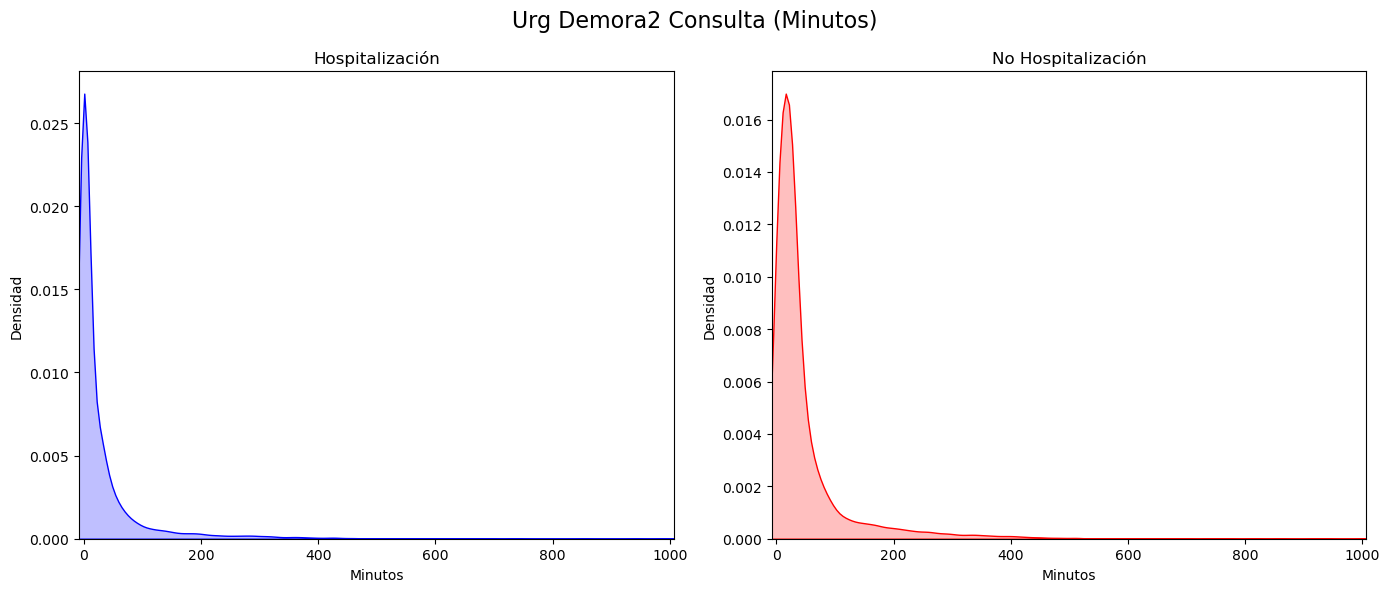

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos para 'Hospitalizacion' y 'No hospitalizacion'
hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'Hospitalizacion']
no_hospitalizacion = df_31[df_31['Tipo Egreso (INTERNACION)'] == 'No hospitalizacion']

# Obtener los rangos máximos y mínimos de la variable 'Minutos (Camara - Triaje)'
min_value = min(hospitalizacion['Urg Demora2 Consulta (Minutos)'].min(), no_hospitalizacion['Urg Demora2 Consulta (Minutos)'].min())
max_value = max(hospitalizacion['Urg Demora2 Consulta (Minutos)'].max(), no_hospitalizacion['Urg Demora2 Consulta (Minutos)'].max())

# Crear dos subplots con gráficos de densidad
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=hospitalizacion['Urg Demora2 Consulta (Minutos)'], shade=True, color='blue')
plt.title('Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')
plt.xlim(min_value, max_value)

plt.subplot(1, 2, 2)
sns.kdeplot(data=no_hospitalizacion['Urg Demora2 Consulta (Minutos)'], shade=True, color='red')
plt.title('No Hospitalización')
plt.xlabel('Minutos')
plt.ylabel('Densidad')
plt.xlim(min_value, max_value)


plt.suptitle('Urg Demora2 Consulta (Minutos)', fontsize=16)
plt.tight_layout()
plt.tight_layout()
plt.show()


Las graficas anteriores que representan el tiempo desde que se lee la cedula hasta F3, hasta triaje, y tiempo del F3, respectivamente. Muestran cierta tendencia, y es que en los pacientes nos Hospitalizados, los tiempos fueron levemente mayores, para los tres casos, y aunque se necesitan mas pruebas estadisticas para respaldar tal afirmación, dada la cantidad de variables no es producitvo tanto trabajo de analisis por unas pocas. Por ende, se afirmará que "son importantes y podrian ayudar al proceso de clasificacion".

In [116]:
# Mostrar las últimas 15 columnas del DataFrame
df_31.iloc[:, -20:]


,Dx Relacionado3 Cod,Unidad,Grupo Edad,Paciente Sexo,Clasificacion 1 Triaje \nEnfermeria,Ubicacion Urgencias,Causa Externa (Riesgo),Modalidad Atencion,Ubicación Triaje,Profesional Identificacion,Tiempo Duracion Diligenciamiento F3,Hora Diligenciamiento F3,Minutos,Triaje Re-clasificado,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO,Hora,Hora Ingreso
1,NaN,AÑOS,60-64,FEMENINO,TRIAJE 3,OBSERVACION,ENFERMEDAD GENERAL,URGENCIAS,TRAUMA,1.163025e+11,18:48,0.638356,56.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,14.0,14.0
2,NaN,AÑOS,60-64,FEMENINO,TRIAJE 3,ALTA,ENFERMEDAD GENERAL,URGENCIAS,CONSULTORIO 1,8.036132e+10,18:55,0.821887,79.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,18.0,18.0
3,NaN,AÑOS,75-79,MASCULINO,NO APLICA,XPRESS,ENFERMEDAD GENERAL,REMITIDO,XPRESS,1.047977e+11,0,0.712373,0.0,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,11.0,11.0
4,NaN,AÑOS,70-74,MASCULINO,TRIAJE 3,OBSERVACION,ENFERMEDAD GENERAL,URGENCIAS,CONSULTORIO 1,7.425727e+10,30:32,0.503935,108.0,SI,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,10.0,10.0
5,NaN,AÑOS,5-9,MASCULINO,TRIAJE 3,OBSERVACION,ENFERMEDAD GENERAL,URGENCIAS,CONSULTORIO PEDIATRIA,1.310760e+11,5:41,0.845150,17.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,19.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,NaN,AÑOS,40-44,MASCULINO,TRIAJE 3,OBSERVACION,ENFERMEDAD GENERAL,URGENCIAS,CONSULTORIO 1,1.543998e+11,22:27,0.150648,36.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN,NaN
39740,NaN,AÑOS,85-89,MASCULINO,TRIAJE 3,XPRESS,ENFERMEDAD GENERAL,REMITIDO,CONSULTORIO 4,8.571620e+10,nan,0.141713,74.0,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN,NaN
39741,NaN,AÑOS,50-54,MASCULINO,TRIAJE 3,OBSERVACION,ACCIDENTE DE TRANSITO,URGENCIAS,TRAUMA,1.058367e+11,10:48,0.414919,34.0,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN,NaN
39742,NaN,AÑOS,50-54,MASCULINO,TRIAJE 3,XPRESS,ACCIDENTE DE TRANSITO,URGENCIAS,XPRESS,7.018706e+10,nan,0.507465,48.0,NO,True,POBLACIÓN GENERAL,NEGRO (A). MULATO (A). AFROCOLOMBIANO (A) O AF...,ZNO ALTO COSTO,NaN,NaN


In [82]:
elementos_unicos_Especialista = df_31['Profesional Especialidad'].value_counts()
print("Elementos únicos en la variable 'Profesional Especialidad' y su cantidad:")
print(elementos_unicos_Especialista)

Elementos únicos en la variable 'Profesional Especialidad' y su cantidad:
Profesional Especialidad
MEDICINA GENERAL                               31718
PEDIATRIA                                       2893
URGENTOLOGIA                                    1805
INTENSIVISTA                                     114
PEDIATRÍA                                         37
ESTUDIANTE                                        32
ENSAYO CLINICO                                    28
PSIQUIATRIA                                        8
CIRUGIA GENERAL                                    6
ORTOPEDIA                                          5
ANESTESIOLOGIA                                     5
MEDICINA INTERNA                                   5
GERIATRIA                                          4
CIRUGIA TORAX                                      2
CIRUGIA DE CABEZA Y CUELLO                         2
CIRUGIA PLASTICA- MAXILOFACIAL Y DE LA MANO        1
NEUROLOGIA                                         1


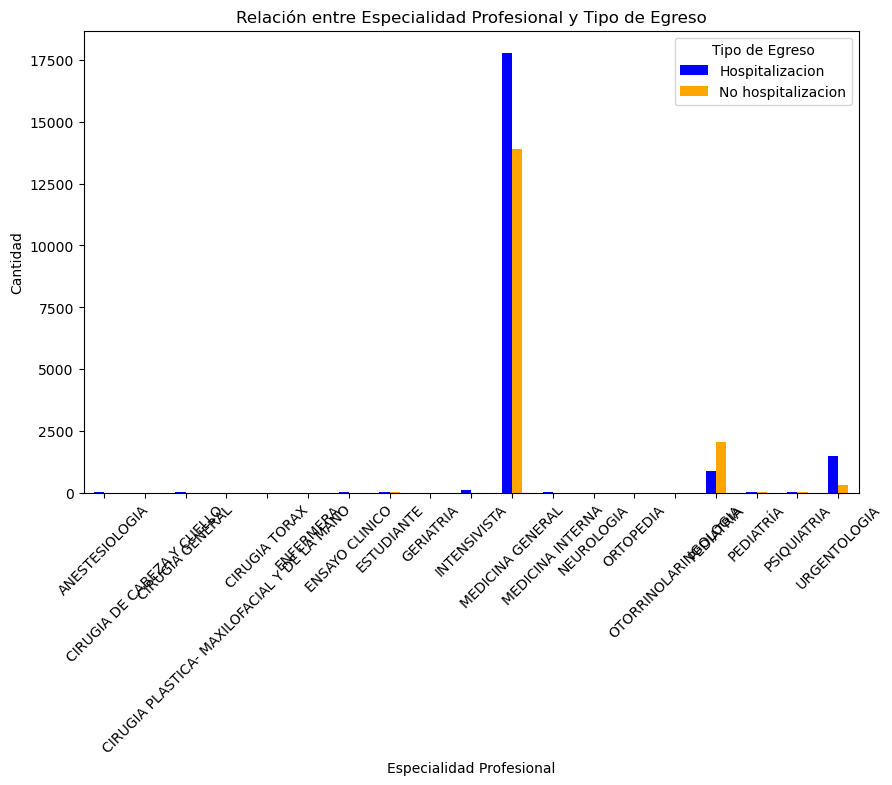

In [83]:
# Agrupar por 'Profesional Especialidad' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_profesional_especialidad = df_31.groupby(['Profesional Especialidad', 'Tipo Egreso (INTERNACION)']).size().unstack()

conteo_profesional_especialidad.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))
plt.title('Relación entre Especialidad Profesional y Tipo de Egreso')
plt.xlabel('Especialidad Profesional')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

plt.show()


La variables mostrada: Profesional especialidad, se observa que tiene un comportamiento similar para todos los datos que esta posee, aunque si se enfatiza en pediatria puede notarse una desviacion de este comportamiento, por lo que esta variable si alberga informacion sobre el proceso de clasificacion, en muy poca medida respecto a otras analizadas, pero aun así puede aportar al proceso de modelado que se viene.

In [98]:
elementos_unicos_DiagTipo = df_31['Dx Principal Tipo '].value_counts()
print("Elementos únicos en la variable 'Diagnostico Principal Tipo' y su cantidad:")
print(elementos_unicos_DiagTipo)

Elementos únicos en la variable 'Diagnostico Principal Tipo' y su cantidad:
Dx Principal Tipo 
NUEVO       27568
REPETIDO     9100
Name: count, dtype: int64


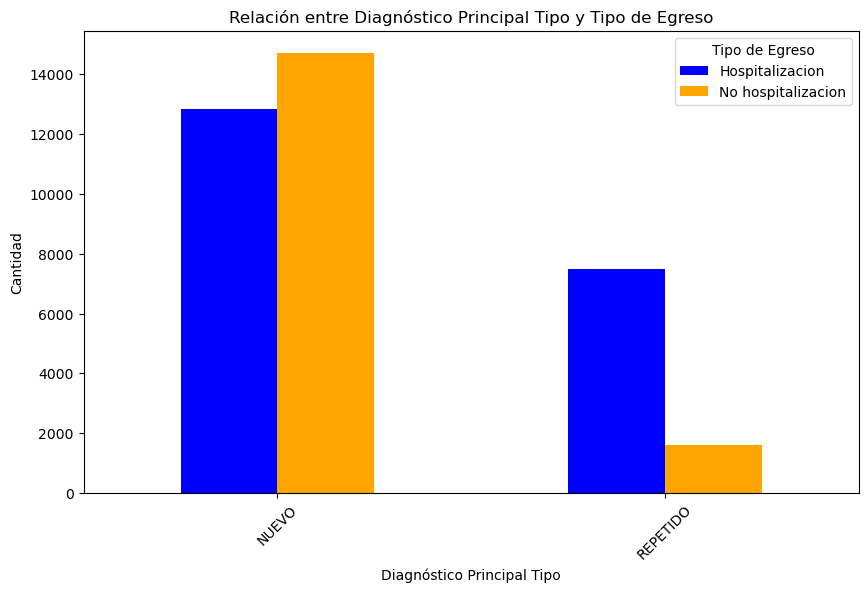

In [99]:

conteo_diagnostico_principal = df_31.groupby(['Dx Principal Tipo ', 'Tipo Egreso (INTERNACION)']).size().unstack()

# Grafiquita de barras
conteo_diagnostico_principal.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))
plt.title('Relación entre Diagnóstico Principal Tipo y Tipo de Egreso')
plt.xlabel('Diagnóstico Principal Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')
plt.show()


La variable "Dx principal Tipo" muestra ser de caracter importante para determinar si un paciente se queda en Hospitalizacion o no, ya que se observan comportamientos diferentes con los datos que se tienen, es decir contiene informacion importante para el proceso de clasificación.

La variable Dx Principal Cod evidentemente resultará de importancia en el proceso de clasificacion, ademas de ello, debido a incongruencias con otra variable que es Dx Principal Cod.1 (la cual deberia tener la misma data), ambas serán tomadas en cuenta en el proceso de modelado (no se encuentra correlacion alguna entre ellas)

In [103]:
elementos_unicos_DiagTipo = df_31['Dx Principal Cod.1'].value_counts()
print("Elementos únicos en la variable 'Diagnostico Principal Tipo' y su cantidad:")
print(elementos_unicos_DiagTipo)  

Elementos únicos en la variable 'Diagnostico Principal Tipo' y su cantidad:
Dx Principal Cod.1
S00-T98    9953
R00-R99    8616
J00-J99    2822
I00-I99    2402
N00-N99    2216
K00-K93    1926
A00-B99    1501
M00-M99    1364
C00-D48    1055
F00-F99     904
G00-G99     729
L00-L99     722
E00-E90     564
H60-H95     508
Z00-Z99     446
H00-H59     351
D50-D89     310
V01-Y98     209
Q00-Q99      48
P00-P96      15
U00-U99       5
O00-O99       2
Name: count, dtype: int64


Las siguientes variables a analizar son Dx Relacionado1 Cod, Dx Relacionado2 Cod y Dx Relacionado3 Cod, se analizará la cantidad de pacientes con cada uno de estos, es decir aquellos que tienen un solo diagnostico relacionado, aquellos que tiene dos y los que tienen tres, sin enfocarse en cual es el diagnostico especificamente, así:

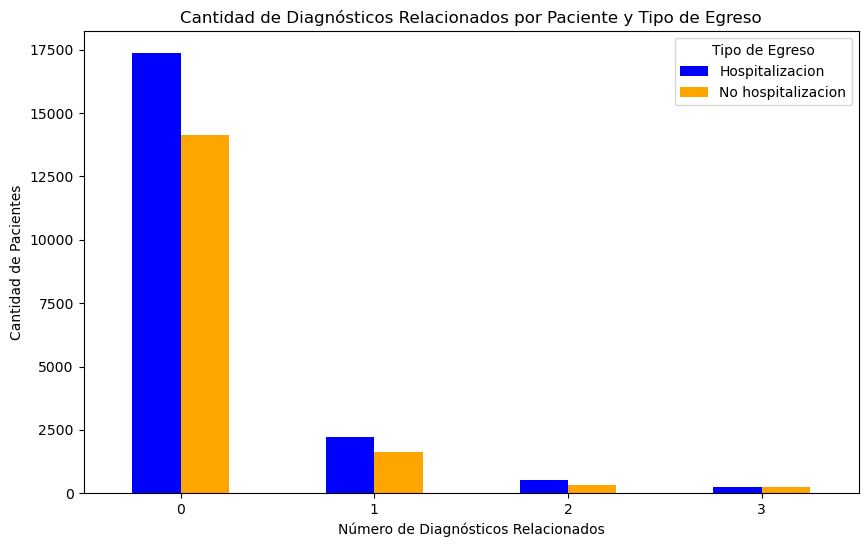

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar el número de diagnósticos relacionados para cada paciente
df_31['Num_Diagnosticos'] = df_31[['Dx Relacionado1 Cod', 'Dx Relacionado2 Cod ', 'Dx Relacionado3 Cod']].notna().sum(axis=1)

# Agrupar por 'Num_Diagnosticos' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_diagnosticos = df_31.groupby(['Num_Diagnosticos', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_diagnosticos.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Cantidad de Diagnósticos Relacionados por Paciente y Tipo de Egreso')
plt.xlabel('Número de Diagnósticos Relacionados')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


En los 4 casos se observan las mismas tendencias, donde el numero de pacientes en Hospitalizacion fue mayor, asi que inicialemnte el numero de diagnosticos secuendarios no representa informacion suficiente para clsificarlo, pero se eespera que el diagnostico como tal aporte tal informacion. Por ende, estas tres variables se dejaran tambien considerandose como de importancia

In [114]:
# Eliminar la columna 'Num_Diagnosticos'
df_31.drop(columns=['Num_Diagnosticos'], inplace=True)

In [119]:
elementos_unicos_Unidad = df_31['Unidad'].value_counts()
print("Elementos únicos en la variable 'Unidad' y su cantidad:")
print(elementos_unicos_Unidad)  

Elementos únicos en la variable 'Unidad' y su cantidad:
Unidad
AÑOS     35713
MESES      917
DÍAS        38
Name: count, dtype: int64


Ya que la mayoria de los datos estan en la Unidad de años, el analisis se hara suponiendo que todos estan en años para facilidad del codigo:

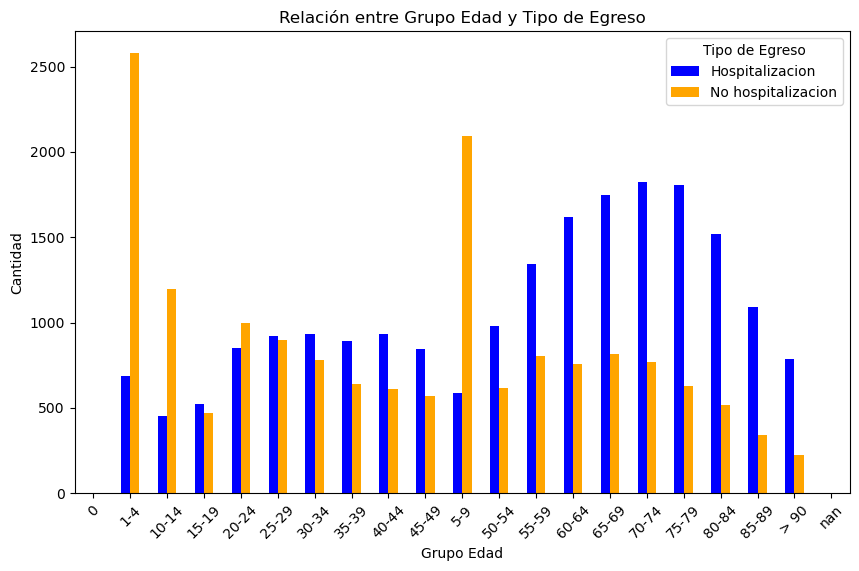

In [120]:
# Agrupar por 'Grupo Edad' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_grupo_edad = df_31.groupby(['Grupo Edad', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)


conteo_grupo_edad.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

plt.title('Relación entre Grupo Edad y Tipo de Egreso')
plt.xlabel('Grupo Edad')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

plt.show()


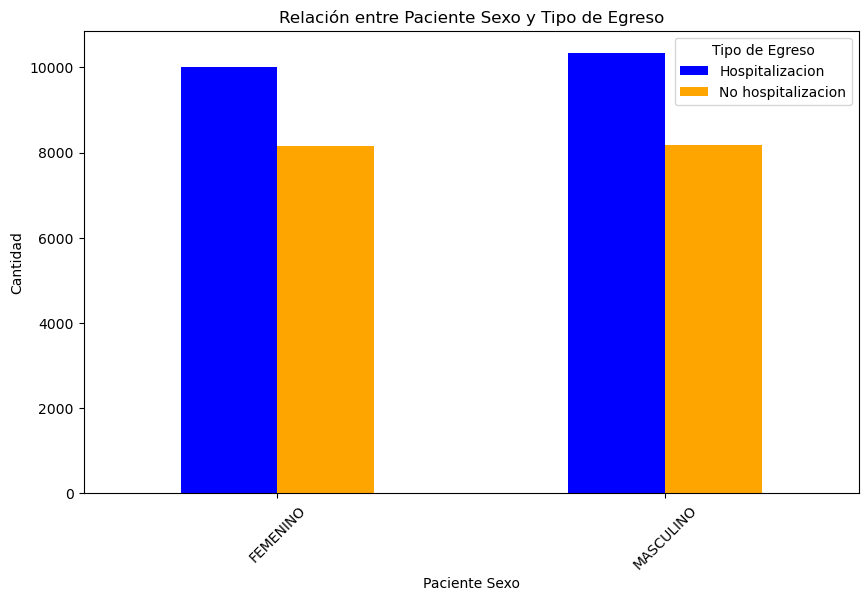

In [121]:
# Agrupar por 'Paciente Sexo' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_paciente_sexo = df_31.groupby(['Paciente Sexo', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

conteo_paciente_sexo.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))
plt.title('Relación entre Paciente Sexo y Tipo de Egreso')
plt.xlabel('Paciente Sexo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


Las dos graficas anteriores muestras que la variables Grupo Edad tiene informacion importante para clasificacion, ya que se observan diferentes tendencias para diferentes grupos; algunos poseen mayor cantidad de pacientes en No Hospitalizacion, demostrando entonces el caracter de clasificacion de la variable, mientras que para la variable Sexo Paciente, no se observo comportamiento alguno que indicara una distincion entre Hospitalizacion y No Hospitalizacion entre los dos sexos, por ende no aporta tanta informacion al proceso de clasificacion, pero de igual forma, permanecerá.

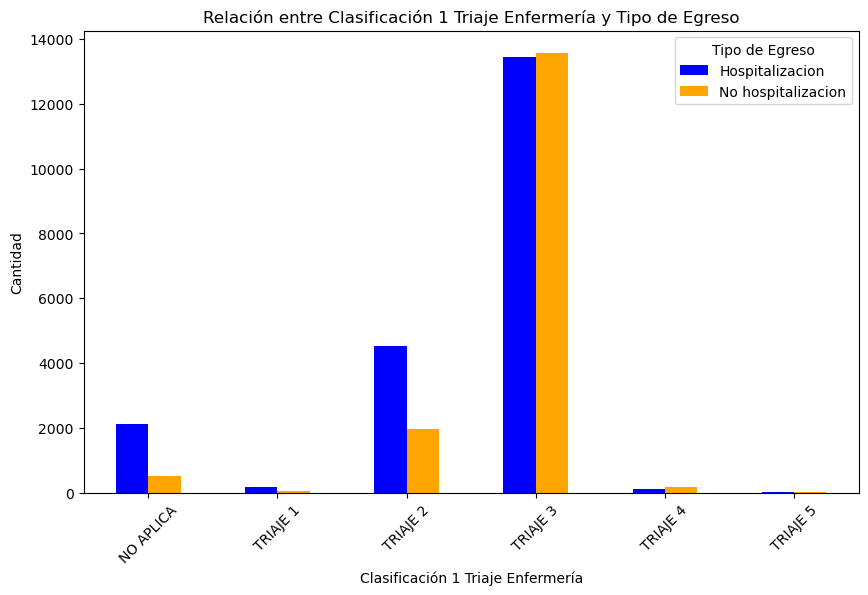

In [123]:
# Agrupar por 'Clasificacion 1 Triaje \nEnfermeria' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_triaje_enfermeria = df_31.groupby(['Clasificacion 1 Triaje \nEnfermeria ', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_triaje_enfermeria.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre Clasificación 1 Triaje Enfermería y Tipo de Egreso')
plt.xlabel('Clasificación 1 Triaje Enfermería')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


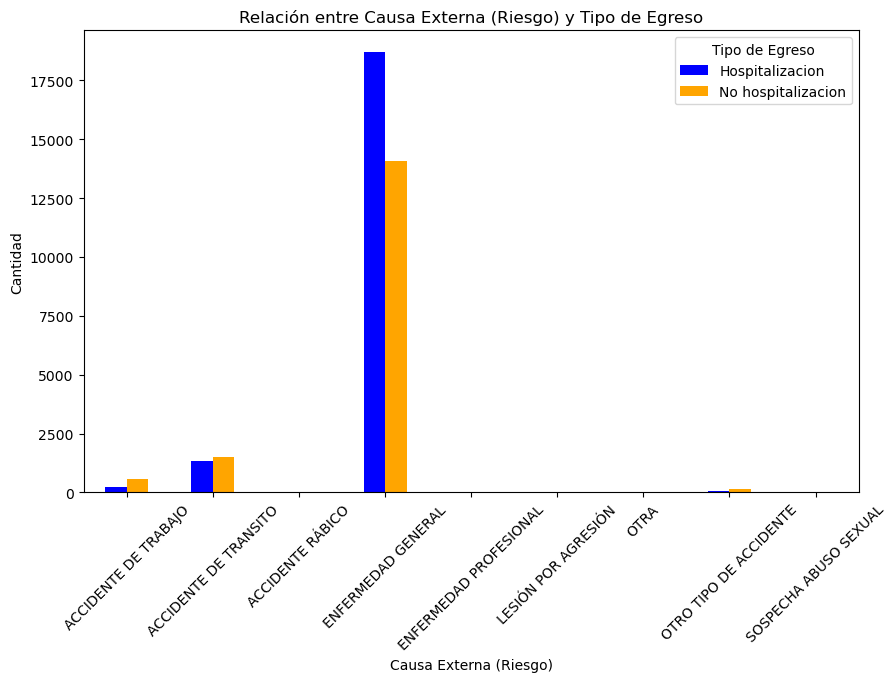

In [133]:
# Agrupar por 'Causa Externa (Riesgo)' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_causa_externa = df_31.groupby(['Causa Externa  (Riesgo)', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_causa_externa.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre Causa Externa (Riesgo) y Tipo de Egreso')
plt.xlabel('Causa Externa (Riesgo)')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


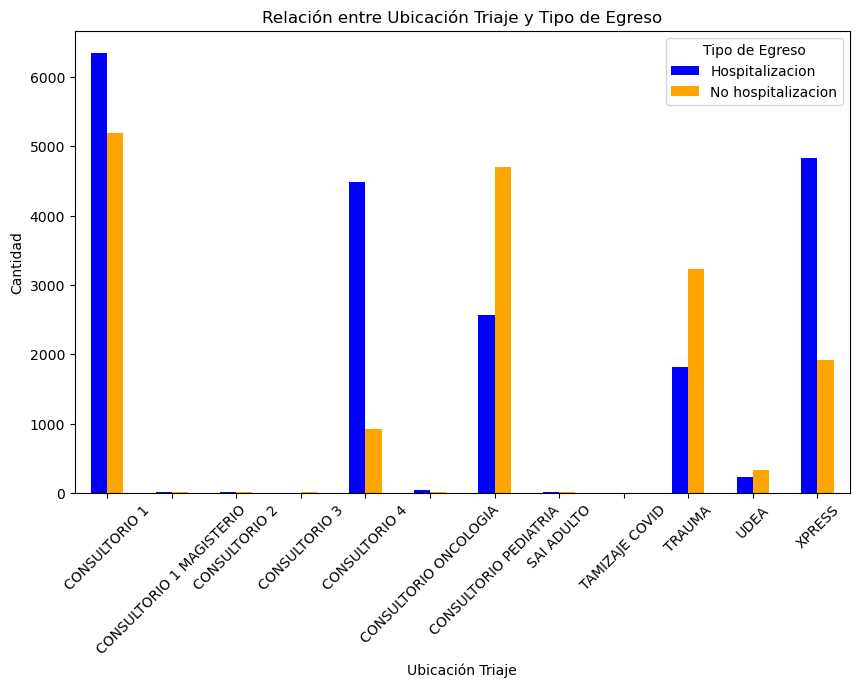

In [134]:
# Agrupar por 'Ubicación Triaje' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_ubicacion_triaje = df_31.groupby(['Ubicación Triaje', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_ubicacion_triaje.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre Ubicación Triaje y Tipo de Egreso')
plt.xlabel('Ubicación Triaje')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


Las anteriores variables mostraron contener informacion para el proceso de clasificacion.

In [135]:
df_31['Hora'].corr(df_31['Hora Ingreso']) # Se observa alta correlacion

0.9348223235343757

In [136]:
df_31.drop(columns=['Hora'], inplace=True)

In [139]:
df_31.drop(columns=['Minutos'], inplace=True)

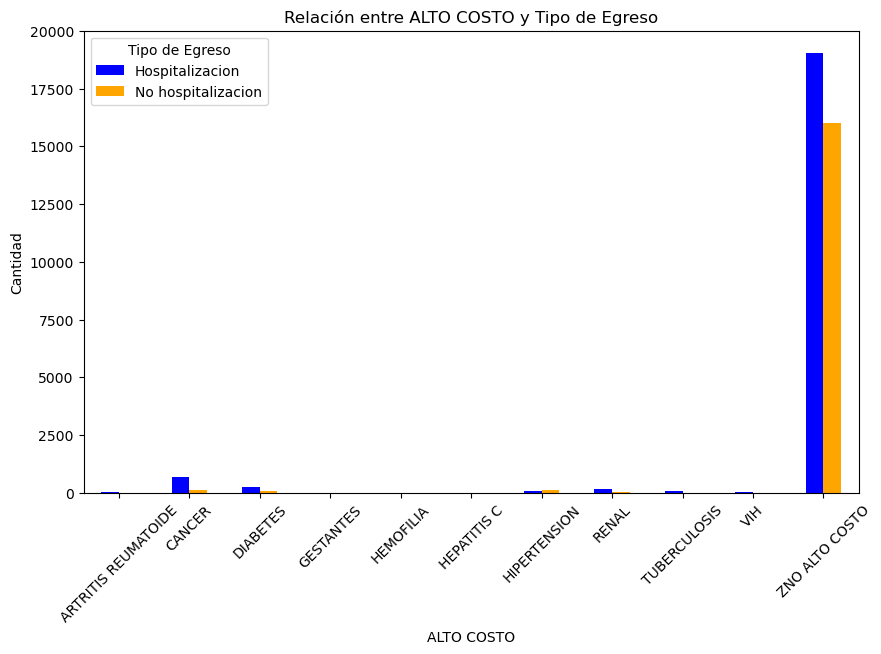

In [137]:
# Agrupar por 'ALTO COSTO' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_alto_costo = df_31.groupby(['ALTO COSTO', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_alto_costo.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre ALTO COSTO y Tipo de Egreso')
plt.xlabel('ALTO COSTO')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


Algunas variables presentan muy poca informacion para la clasificacion, incluso nula.

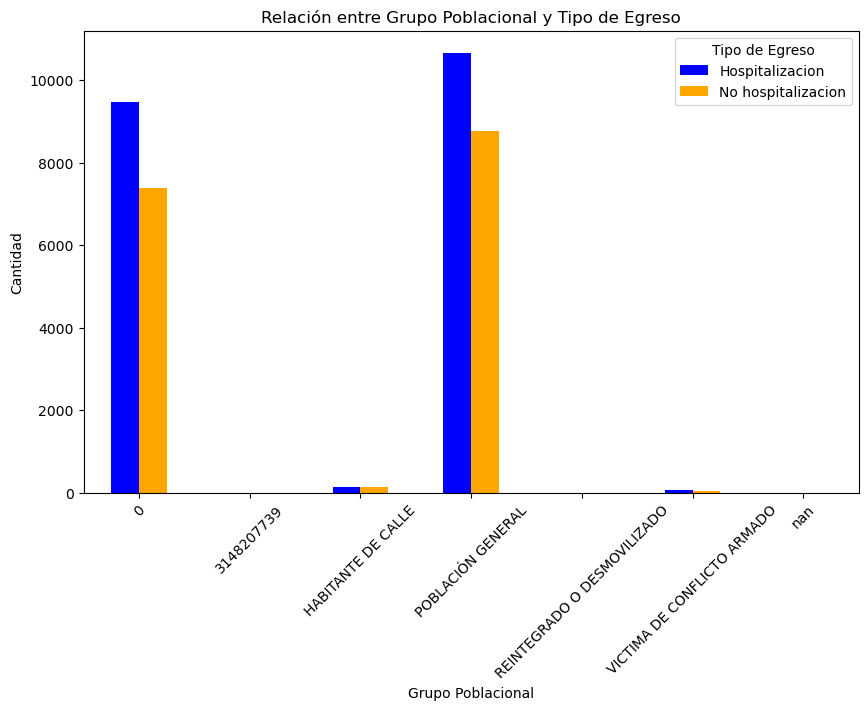

In [138]:
# Agrupar por 'Grupo Poblacional' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_grupo_poblacional = df_31.groupby(['Grupo Poblacional', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_grupo_poblacional.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre Grupo Poblacional y Tipo de Egreso')
plt.xlabel('Grupo Poblacional')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


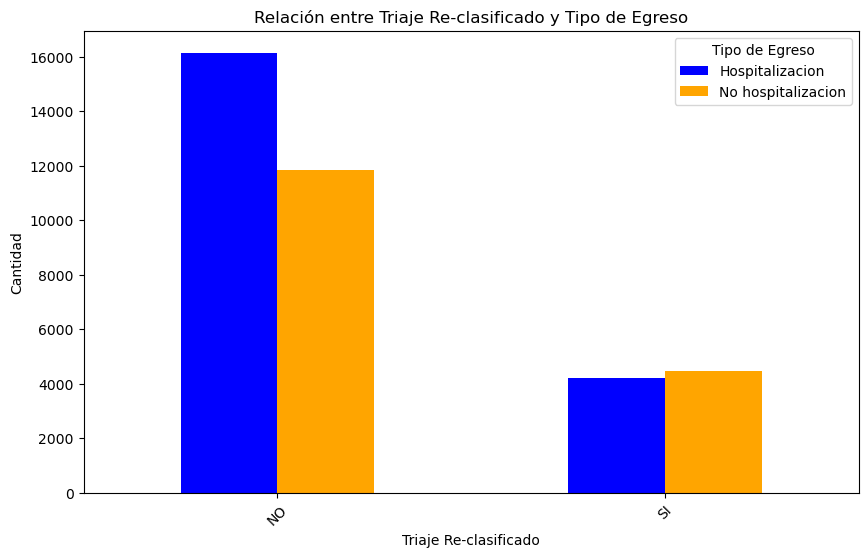

In [140]:
# Agrupar por 'Triaje Re-clasificado' y 'Tipo Egreso (INTERNACION)' y contar las ocurrencias
conteo_triaje_reclasificado = df_31.groupby(['Triaje Re-clasificado', 'Tipo Egreso (INTERNACION)']).size().unstack().fillna(0)

# Crear la gráfica de barras
conteo_triaje_reclasificado.plot(kind='bar', color=['blue', 'orange'], figsize=(10, 6))

# Agregar títulos y etiquetas
plt.title('Relación entre Triaje Re-clasificado y Tipo de Egreso')
plt.xlabel('Triaje Re-clasificado')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Egreso')

# Mostrar la gráfica
plt.show()


De esta manera, se observa cuales variables presentan mayor o menos importancia en el proceso de clasificacion, tal analisis, mejor dicho las graficas, permitira realizar un proceso de codificacion de los datos mas certero y preciso, permitiendo que el modelo capte la mayor cantidad de informacion presente sobre cada una de las variables para el proceso de clasificación. Además de dar información que pueda ser contrastada con los profesionales del area para verificar correcto procesamiento de los datos.

QUEDANDO LA SIGUIENTE BASE DE DATOS:

In [141]:
df_31

,DESCRIPCION,Mes,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha Ingreso,Urg Fecha Triaje,Urg Fecha Consulta F3,Minutos (Camara - F3),...,Ubicación Triaje,Profesional Identificacion,Tiempo Duracion Diligenciamiento F3,Hora Diligenciamiento F3,Triaje Re-clasificado,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO,Hora Ingreso
1,URGENCIAS ADULTO,ENERO,No hospitalizacion,5,PGP,SUBSIDIADO,2023-01-01 14:36:29.597,2023-01-01 14:23:34.717000,2023-01-01 15:19:13.777000,65.133333,...,TRAUMA,1.163025e+11,18:48,0.638356,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,14.0
2,URGENCIAS ADULTO,ENERO,No hospitalizacion,65,EVENTO,ESPECIAL,2023-01-07 18:32:07.223,2023-01-07 18:24:41.357000,2023-01-07 19:43:31.250000,82.050000,...,CONSULTORIO 1,8.036132e+10,18:55,0.821887,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,18.0
3,URGENCIAS ADULTO,ENERO,Hospitalizacion,48,EVENTO,CONTRIBUTIVO,2023-01-11 11:19:16.800,NaN,2023-01-11 17:05:49.203000,0.000000,...,XPRESS,1.047977e+11,0,0.712373,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,11.0
4,URGENCIAS ADULTO,ENERO,Hospitalizacion,19,EVENTO,CONTRIBUTIVO,2023-01-07 10:40:49.950,2023-01-07 10:17:25.067000,2023-01-07 12:05:40.207000,116.850000,...,CONSULTORIO 1,7.425727e+10,30:32,0.503935,SI,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,10.0
5,URGENCIAS PEDIATRICAS,ENERO,No hospitalizacion,48,EVENTO,CONTRIBUTIVO,2023-01-01 20:04:34.377,2023-01-01 20:00:38.977000,2023-01-01 20:17:01.273000,21.450000,...,CONSULTORIO PEDIATRIA,1.310760e+11,5:41,0.845150,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,URGENCIAS ADULTO,DICIEMBRE,No hospitalizacion,65,EVENTO,ESPECIAL,NaT,31/12/2023 3:00:41,31/12/2023 3:36:56,50.133333,...,CONSULTORIO 1,1.543998e+11,22:27,0.150648,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN
39740,URGENCIAS ADULTO,DICIEMBRE,Hospitalizacion,4,EVENTO,SUBSIDIADO,NaT,17/12/2023 2:10:47,17/12/2023 3:24:04,0.000000,...,CONSULTORIO 4,8.571620e+10,nan,0.141713,NO,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN
39741,URGENCIAS ADULTO,DICIEMBRE,No hospitalizacion,18,EVENTO,NO ASEGURADO,NaT,25/12/2023 9:23:32,25/12/2023 9:57:29,40.900000,...,TRAUMA,1.058367e+11,10:48,0.414919,NO,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO,NaN
39742,URGENCIAS ADULTO,DICIEMBRE,No hospitalizacion,18,EVENTO,NO ASEGURADO,NaT,29/12/2023 11:22:22,29/12/2023 12:10:45,0.000000,...,XPRESS,7.018706e+10,nan,0.507465,NO,True,POBLACIÓN GENERAL,NEGRO (A). MULATO (A). AFROCOLOMBIANO (A) O AF...,ZNO ALTO COSTO,NaN
